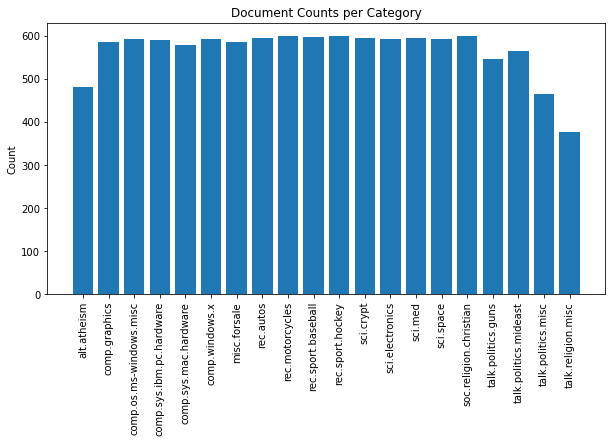

In [1]:
#Q1
import numpy as np
np.random.seed(42)
import random
random.seed(42)

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_20newsgroups

plt.rcParams['figure.figsize'] = [10,5]

twenty_plot = fetch_20newsgroups(subset='train')
labels = twenty_plot.target_names

y = list(range(20))
for i in range(20):
    y[i] = np.count_nonzero(twenty_plot.target == i)

plt.bar(labels,y)
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Document Counts per Category")
plt.show()

In [2]:
#Q2
#Questions for TA:
#random_state for dataset fetch? None or 42? 42 used in discussion but project doc says None

import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from nltk.corpus import stopwords

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

lemur = nltk.wordnet.WordNetLemmatizer()

#Vectorizer
analyzer = CountVectorizer().build_analyzer()
tfidf_transformer = TfidfTransformer()

#Download dataset
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42) #should 42 be None?
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42)

combined_stopwords = set.union(set(stopwords.words('english')),set(punctuation))

def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(text):
    return [lemur.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(text)]

#Updated analyzer to avoid counting digits and punctuation
def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

count_vect = CountVectorizer(min_df=3,analyzer=stem_rmv_punc, stop_words='english')

corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]

#X_train_counts = count_vect.fit_transform(corpus)

X_train_counts = count_vect.fit_transform(train_dataset.data)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(test_dataset.data)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

print("X_train shape: ", X_train_tfidf.shape)
print("X_test shape: ", X_test_tfidf.shape)



X_train shape:  (4732, 16466)
X_test shape:  (3150, 16466)


In [3]:
#Q3
#Questions for TA:
#random_state for nmf and trunc svd? 0 or 42? 

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.utils.extmath import randomized_svd

trunc_svd = TruncatedSVD(n_components=50, random_state=0)
X_train_lsi = trunc_svd.fit_transform(X_train_tfidf)
X_test_lsi = trunc_svd.transform(X_test_tfidf)

#Get trunc svd matrices
#https://stackoverflow.com/questions/31523575/get-u-sigma-v-matrix-from-truncated-svd-in-scikit-learn
U, Sigma, VT = randomized_svd(X_train_tfidf, n_components=50, random_state=0)
Sigma = np.diag(Sigma) #Make sigma values a diag matrix rather than nx1

nmf_model = NMF(n_components=50, init='random', random_state=0)
X_train_nmf = nmf_model.fit_transform(X_train_tfidf)
X_test_nmf = nmf_model.transform(X_test_tfidf)
H = nmf_model.components_
error_lsi = np.sum(np.array(X_train_tfidf - U.dot(Sigma.dot(VT)))**2)
error_nmf = np.sum(np.array(X_train_tfidf - X_train_nmf.dot(H))**2)

print('LSI Train error: ', error_lsi)
print('NMF Train error: ', error_nmf)

print('LSI Train shape: ', X_train_lsi.shape)
print('LSI Test shape: ', X_test_lsi.shape)
print('NMF Train shape: ', X_train_nmf.shape)
print('NMF Test shape: ', X_test_nmf.shape)

LSI Train error:  4099.651344825857
NMF Train error:  4143.541730848815
LSI Train shape:  (4732, 50)
LSI Test shape:  (3150, 50)
NMF Train shape:  (4732, 50)
NMF Test shape:  (3150, 50)


Soft margin prediction stats:
              precision    recall  f1-score   support

           0     1.0000    0.3372    0.5043      1560
           1     0.6059    1.0000    0.7546      1590

    accuracy                         0.6717      3150
   macro avg     0.8030    0.6686    0.6295      3150
weighted avg     0.8011    0.6717    0.6307      3150

Hard margin prediction stats:
              precision    recall  f1-score   support

           0     0.9799    0.9686    0.9742      1560
           1     0.9695    0.9805    0.9750      1590

    accuracy                         0.9746      3150
   macro avg     0.9747    0.9745    0.9746      3150
weighted avg     0.9747    0.9746    0.9746      3150

current gamma: 10^-3
accs: [0.8528169  0.92746479 0.96901408 0.95070423 0.75774648]
avg: 0.8915492957746478
current gamma: 10^-2
accs: [0.96197183 0.95915493 0.96830986 0.96760563 0.95211268]
avg: 0.9618309859154929
current gamma: 10^-1
accs: [0.97394366 0.95985915 0.97253521 0.9697183

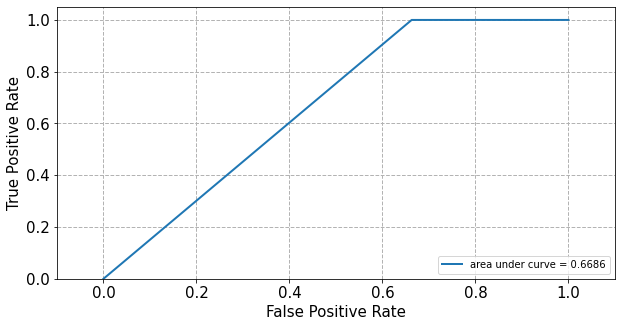

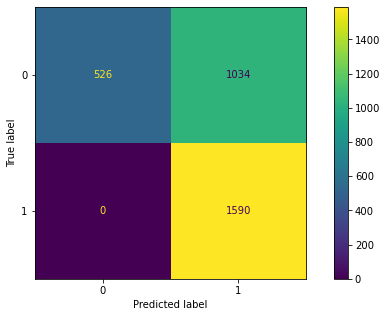

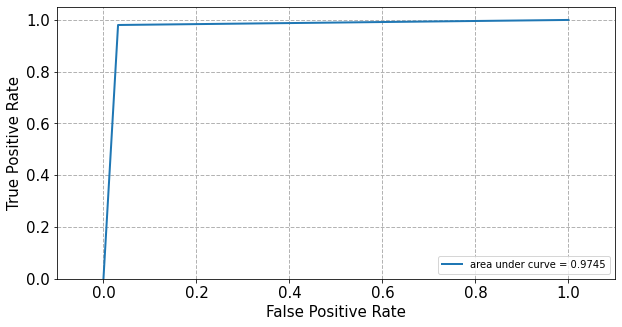

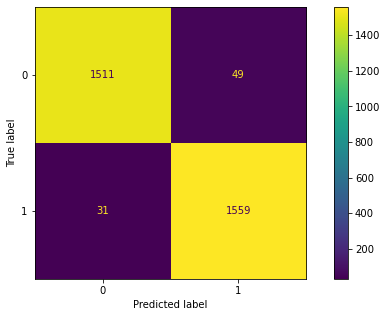

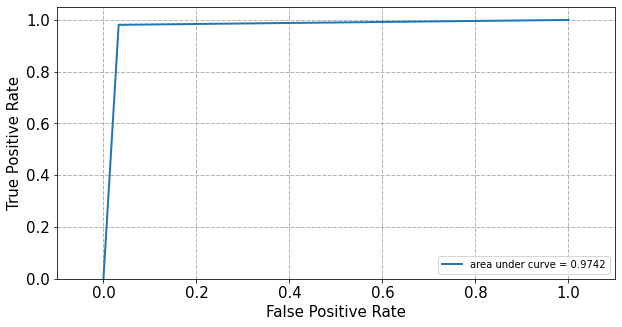

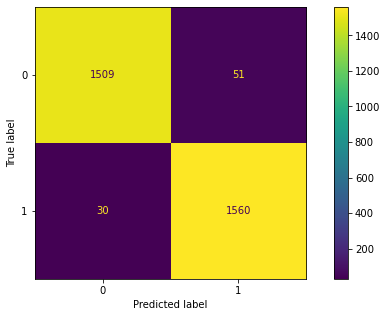

In [22]:
#Q4
from sklearn.svm import LinearSVC
from sklearn import metrics

#Start by changing to binary classification
train_targets_bin = train_dataset.target.copy()
for i in range(len(train_targets_bin)):
    if train_dataset.target[i] in [0,1,2,3]:
        train_targets_bin[i] = 0
    else:
        train_targets_bin[i] = 1
        
test_targets_bin = test_dataset.target.copy()
for i in range(len(test_targets_bin)):
    if test_dataset.target[i] in [0,1,2,3]:
        test_targets_bin[i] = 0
    else:
        test_targets_bin[i] = 1

#Train hard and soft margin SVCs - using LSI data per instructions - then get stats
soft_margin_SVC = LinearSVC(C=0.0001,max_iter=90000).fit(X_train_lsi, train_targets_bin)
soft_margin_prediction = soft_margin_SVC.predict(X_test_lsi)

hard_margin_SVC = LinearSVC(C=1000,max_iter=90000).fit(X_train_lsi, train_targets_bin)
hard_margin_prediction = hard_margin_SVC.predict(X_test_lsi)

fpr_soft, tpr_soft, thresholds_soft = metrics.roc_curve(test_targets_bin, soft_margin_prediction, pos_label=1)
fpr_hard, tpr_hard, thresholds_hard = metrics.roc_curve(test_targets_bin, hard_margin_prediction, pos_label=1)

#I stole this helper function from the discussion notebook!
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = metrics.auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)
        
#Show the stats for our model (part 1 of question)       
plot_roc(fpr_soft,tpr_soft)
metrics.plot_confusion_matrix(soft_margin_SVC, X_test_lsi, test_targets_bin)
print("Soft margin prediction stats:")
print(metrics.classification_report(test_targets_bin,soft_margin_prediction,digits=4))

plot_roc(fpr_hard,tpr_hard)
metrics.plot_confusion_matrix(hard_margin_SVC, X_test_lsi, test_targets_bin)
print("Hard margin prediction stats:")
print(metrics.classification_report(test_targets_bin,hard_margin_prediction,digits=4))

#hard margin is much better than soft!

#Part 2!

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

split_data = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

def find_best_gamma(ks):
    best_k = -100
    best_acc = 0
    for i in ks: 
        k_SVC = LinearSVC(C=10**i,max_iter=90000).fit(X_train_lsi, train_targets_bin)
        k_prediction = k_SVC.predict(X_test_lsi)
        scores = cross_val_score(k_SVC, X_train_lsi, train_targets_bin, cv=split_data, scoring='accuracy')
        acc = np.average(scores)
        print("current gamma: 10^" + str(i))
        print("accs: " + str(scores))
        print("avg: " + str(acc))
        if acc > best_acc:
            best_k = i
            best_acc = acc
    return best_k
        
        
k = find_best_gamma([-3,-2,-1,0,1,2,3])

print("my best gamma is 10^" + str(k))

#recalculate model w/best k and report stats
optimal_SVC = LinearSVC(C=10**k,max_iter=50000).fit(X_train_lsi, train_targets_bin)
optimal_prediction = optimal_SVC.predict(X_test_lsi)
fpr_opt, tpr_opt, thresholds_opt = metrics.roc_curve(test_targets_bin, optimal_prediction, pos_label=1)
plot_roc(fpr_opt,tpr_opt)
metrics.plot_confusion_matrix(optimal_SVC, X_test_lsi, test_targets_bin)
print("Optimal prediction stats:")
print(metrics.classification_report(test_targets_bin,optimal_prediction,digits=4))



Mean abs val coefficient for unregularized LR: 13.188082623105863
Non-regularized logistic classifier stats:
              precision    recall  f1-score   support

           0     0.9811    0.9647    0.9729      1560
           1     0.9660    0.9818    0.9738      1590

    accuracy                         0.9733      3150
   macro avg     0.9735    0.9733    0.9733      3150
weighted avg     0.9735    0.9733    0.9733      3150

L1 logistic classifier stats with C = 10^1
              precision    recall  f1-score   support

           0     0.9811    0.9647    0.9729      1560
           1     0.9660    0.9818    0.9738      1590

    accuracy                         0.9733      3150
   macro avg     0.9735    0.9733    0.9733      3150
weighted avg     0.9735    0.9733    0.9733      3150

L2 logistic classifier stats with C = 10^2
              precision    recall  f1-score   support

           0     0.9804    0.9641    0.9722      1560
           1     0.9653    0.9811    0.973

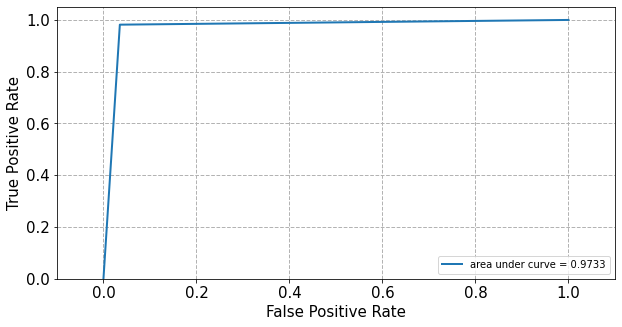

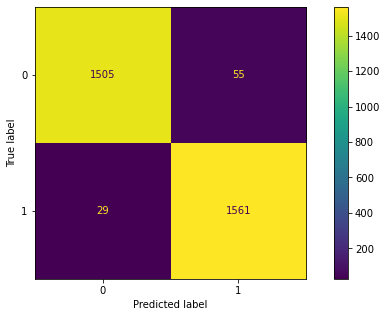

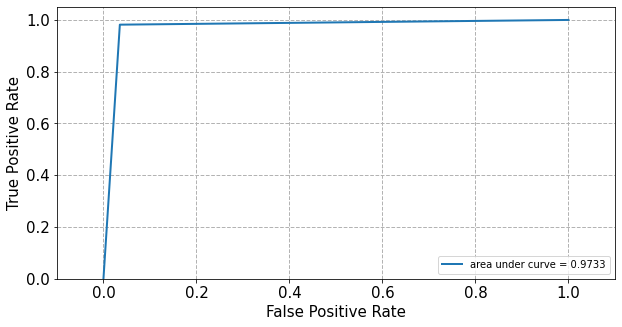

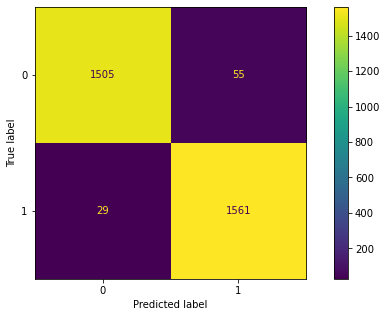

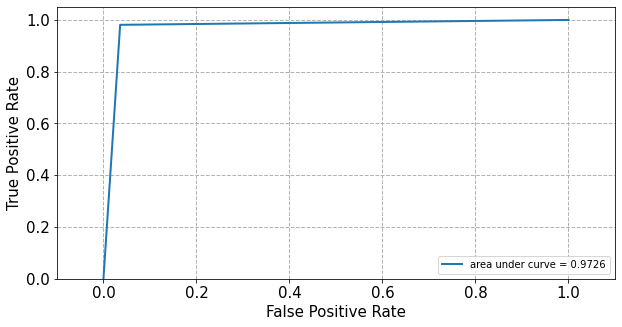

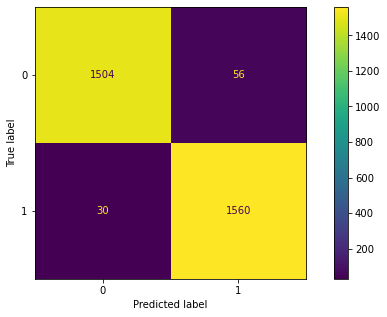

In [26]:
#Q5 
from sklearn.linear_model import LogisticRegression
#Part 1
#C is "Inverse of regularization strength", so a really big value approximates no regularization
log_class_no_reg = LogisticRegression(C=10**10, max_iter=5000).fit(X_train_lsi, train_targets_bin)
log_class_no_reg_prediction = log_class_no_reg.predict(X_test_lsi)
coeffs = (log_class_no_reg.coef_)
print("Mean abs val coefficient for unregularized LR: " + str(np.mean(np.absolute(coeffs))))


fpr, tpr, threshold = metrics.roc_curve(test_targets_bin, log_class_no_reg_prediction, pos_label=1)

plot_roc(fpr,tpr)
metrics.plot_confusion_matrix(log_class_no_reg, X_test_lsi, test_targets_bin)
print("Non-regularized logistic classifier stats:")
print(metrics.classification_report(test_targets_bin,log_class_no_reg_prediction,digits=4))

#Part 2a - finding best regularization parameter
def find_best_reg(ks, reg_type):
    best_k = -100
    best_acc = 0
    for i in ks: 
        k_LR = LogisticRegression(C=10**i, penalty=reg_type,solver='liblinear').fit(X_train_lsi, train_targets_bin)
        k_prediction = k_LR.predict(X_test_lsi)
        scores = cross_val_score(k_LR, X_train_lsi, train_targets_bin, cv=split_data, scoring='accuracy')
        acc = np.average(scores)
        if acc > best_acc:
            best_k = i
            best_acc = acc
    return best_k

k_l1 = find_best_reg([-3,-2,-1,0,1,2,3], "l1")
k_l2 = find_best_reg([-3,-2,-1,0,1,2,3], "l2")

#part 2b: getting stats for optimal l1 and l2 reg parameters (no-reg done in part 1)

#l1 case
log_class_l1 = LogisticRegression(C=10**k_l1, penalty="l1",solver='liblinear').fit(X_train_lsi, train_targets_bin)
log_class_l1_prediction = log_class_l1.predict(X_test_lsi)

fpr_l1, tpr_l1, threshold_l1 = metrics.roc_curve(test_targets_bin, log_class_l1_prediction, pos_label=1)

plot_roc(fpr_l1,tpr_l1)
metrics.plot_confusion_matrix(log_class_l1, X_test_lsi, test_targets_bin)
print("L1 logistic classifier stats with C = 10^" + str(k_l1))
print(metrics.classification_report(test_targets_bin,log_class_l1_prediction,digits=4))

#l2 case
log_class_l2 = LogisticRegression(C=10**k_l2, penalty="l2",solver='liblinear').fit(X_train_lsi, train_targets_bin)
log_class_l2_prediction = log_class_l2.predict(X_test_lsi)

fpr_l2, tpr_l2, threshold_l2 = metrics.roc_curve(test_targets_bin, log_class_l2_prediction, pos_label=1)

plot_roc(fpr_l2,tpr_l2)
metrics.plot_confusion_matrix(log_class_l2, X_test_lsi, test_targets_bin)
print("L2 logistic classifier stats with C = 10^" + str(k_l2))
print(metrics.classification_report(test_targets_bin,log_class_l2_prediction,digits=4))



Naive Bayes classification stats:
              precision    recall  f1-score   support

           0     0.9697    0.8410    0.9008      1560
           1     0.8620    0.9742    0.9147      1590

    accuracy                         0.9083      3150
   macro avg     0.9158    0.9076    0.9077      3150
weighted avg     0.9153    0.9083    0.9078      3150



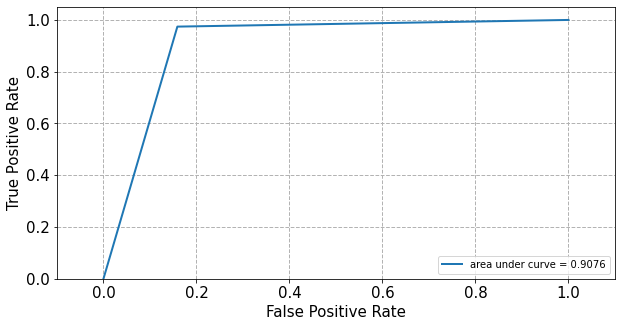

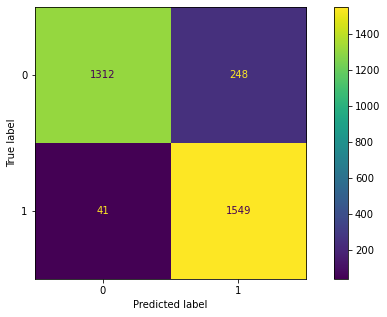

In [24]:
#Q6
from sklearn.naive_bayes import GaussianNB

gauss_NB = GaussianNB().fit(X_train_lsi, train_targets_bin)
gauss_NB_prediction = gauss_NB.predict(X_test_lsi)

fpr_NB, tpr_NB, threshold_NB = metrics.roc_curve(test_targets_bin, gauss_NB_prediction, pos_label=1)

plot_roc(fpr_NB,tpr_NB)
metrics.plot_confusion_matrix(gauss_NB, X_test_lsi, test_targets_bin)
print("Naive Bayes classification stats:")
print(metrics.classification_report(test_targets_bin,gauss_NB_prediction,digits=4))